<a href="https://colab.research.google.com/github/kridtapon/Squeeze-Trigger/blob/main/Squeeze_Trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61


<ipython-input-15-2643554016>:34: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
100%|██████████| 676/676 [01:49<00:00,  6.17it/s]


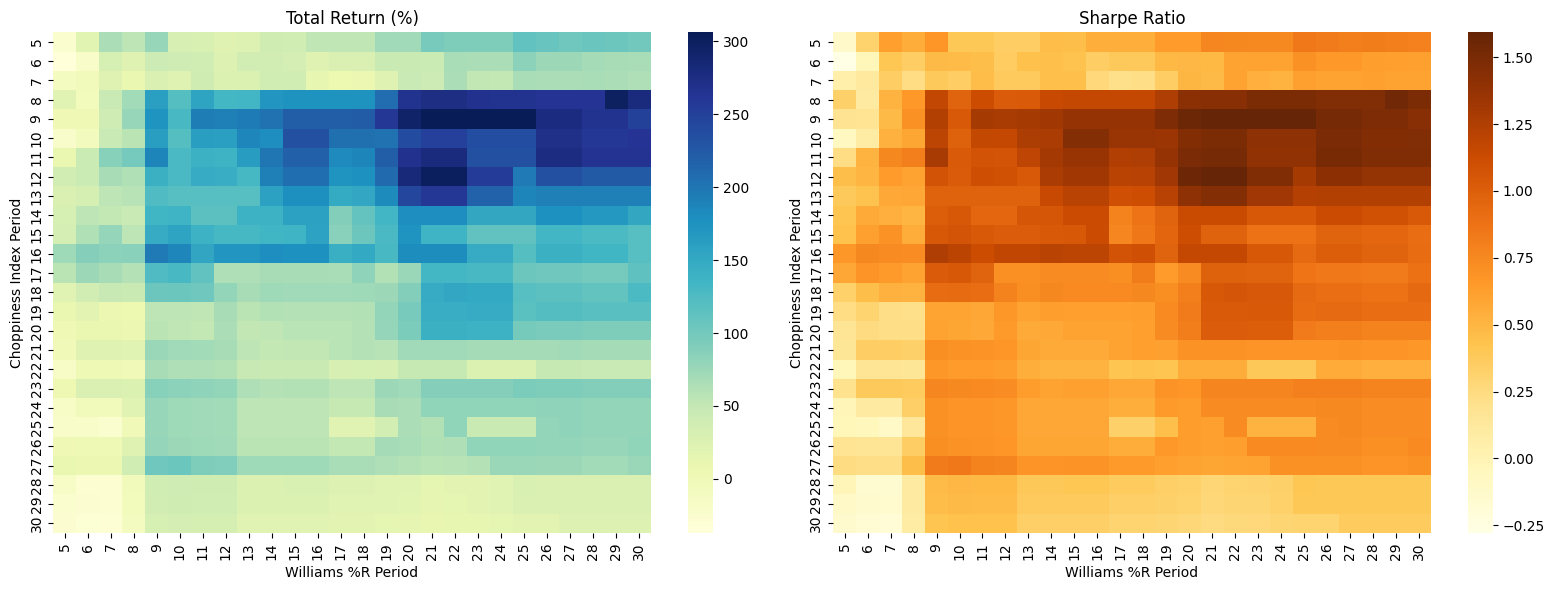

Best Total Return: 306.13% with Choppiness Index Period = 9, Williams %R Period = 21
Best Sharpe Ratio: 1.59 with Choppiness Index Period = 12, Williams %R Period = 21


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm

# ========== Indicators ==========
def calculate_choppiness_index(high, low, close, period=14):
    tr = pd.Series(index=close.index, dtype='float64')
    tr[1:] = np.maximum.reduce([
        high[1:] - low[1:],
        np.abs(high[1:] - close.shift(1)[1:]),
        np.abs(low[1:] - close.shift(1)[1:])
    ])
    atr = tr.rolling(window=period).mean()
    high_max = high.rolling(window=period).max()
    low_min = low.rolling(window=period).min()
    ci = 100 * np.log10(atr.rolling(window=period).sum() / (high_max - low_min)) / np.log10(period)
    return ci

def calculate_williams_r(high, low, close, period=14):
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    williams_r = -100 * (highest_high - close) / (highest_high - lowest_low)
    return williams_r

# ========== Download Data ==========
symbol = 'JCI'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========== Optimization Function ==========
def run_strategy(ci_period, wr_period):
    data = df.copy()
    data['Choppiness'] = calculate_choppiness_index(data['High'], data['Low'], data['Close'], period=ci_period)
    data['WilliamsR'] = calculate_williams_r(data['High'], data['Low'], data['Close'], period=wr_period)

    choppy_entry = data['Choppiness'] < 40
    wr_entry = data['WilliamsR'] > -40
    entry = (choppy_entry & wr_entry)

    choppy_exit = data['Choppiness'] > 60
    wr_exit = data['WilliamsR'] < -80
    exit = (choppy_exit & wr_exit)

    data_test = data[(data.index.year >= 2020) & (data.index.year <= 2025)]
    entry_test = entry[(entry.index.year >= 2020) & (entry.index.year <= 2025)]
    exit_test = exit[(exit.index.year >= 2020) & (exit.index.year <= 2025)]

    shifted_entries = entry_test.shift(1).astype(bool).fillna(False).to_numpy()
    shifted_exits = exit_test.shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=data_test['Open'],
        entries=shifted_entries,
        exits=shifted_exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )
    return pf.stats()['Total Return [%]'], pf.stats()['Sharpe Ratio']

# ========== Parameter Grid ==========
ci_range = range(5, 31)
wr_range = range(5, 31)
results_return = pd.DataFrame(index=ci_range, columns=wr_range, dtype='float64')
results_sharpe = pd.DataFrame(index=ci_range, columns=wr_range, dtype='float64')

for ci_p, wr_p in tqdm(product(ci_range, wr_range), total=len(ci_range)*len(wr_range)):
    total_return, sharpe = run_strategy(ci_p, wr_p)
    results_return.loc[ci_p, wr_p] = total_return
    results_sharpe.loc[ci_p, wr_p] = sharpe

# ========== Plotting Heatmaps ==========
plt.figure(figsize=(16, 6))

# Total Return Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(results_return.astype(float), annot=False, fmt=".1f", cmap="YlGnBu")
plt.title("Total Return (%)")
plt.xlabel("Williams %R Period")
plt.ylabel("Choppiness Index Period")

# Sharpe Ratio Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(results_sharpe.astype(float), annot=False, fmt=".2f", cmap="YlOrBr")
plt.title("Sharpe Ratio")
plt.xlabel("Williams %R Period")
plt.ylabel("Choppiness Index Period")

plt.tight_layout()
plt.show()

# ========== Print Best Parameters ==========

# Best for Total Return
best_return_value = results_return.max().max()
best_return_idx = results_return.stack().idxmax()
print(f"Best Total Return: {best_return_value:.2f}% with Choppiness Index Period = {best_return_idx[0]}, Williams %R Period = {best_return_idx[1]}")

# Best for Sharpe Ratio
best_sharpe_value = results_sharpe.max().max()
best_sharpe_idx = results_sharpe.stack().idxmax()
print(f"Best Sharpe Ratio: {best_sharpe_value:.2f} with Choppiness Index Period = {best_sharpe_idx[0]}, Williams %R Period = {best_sharpe_idx[1]}")


In [16]:
# Calculate indicators
df['Choppiness'] = calculate_choppiness_index(df['High'], df['Low'], df['Close'], period=9)
df['WilliamsR'] = calculate_williams_r(df['High'], df['Low'], df['Close'], period=21)

# Filter data for the test period (2020-2025)
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Entry Conditions
choppy_entry = df_test['Choppiness'] < 40
wr_entry = (df_test['WilliamsR'] > -40)
df_test['Entry'] = choppy_entry & wr_entry

# Exit Conditions
choppy_exit = df_test['Choppiness'] > 60
wr_exit = (df_test['WilliamsR'] < -80)
df_test['Exit'] = choppy_exit & wr_exit

# Shift signals
shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output stats and plot
print(portfolio.stats())
portfolio.plot().show()

<ipython-input-16-1169094219>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-1169094219>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           406128.608264
Total Return [%]                       306.128608
Benchmark Return [%]                   118.446429
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2961.368847
Max Drawdown [%]                        16.988333
Max Drawdown Duration           155 days 00:00:00
Total Trades                                    6
Total Closed Trades                             6
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                         120.515886
Worst Trade [%]                         -5.927562
Avg Winning Trade [%]                   70.091877
Avg Losing Trade [%]                    -3.710303


In [17]:
# Calculate indicators
df['Choppiness'] = calculate_choppiness_index(df['High'], df['Low'], df['Close'], period=12)
df['WilliamsR'] = calculate_williams_r(df['High'], df['Low'], df['Close'], period=21)

# Filter data for the test period (2020-2025)
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Entry Conditions
choppy_entry = df_test['Choppiness'] < 40
wr_entry = (df_test['WilliamsR'] > -40)
df_test['Entry'] = choppy_entry & wr_entry

# Exit Conditions
choppy_exit = df_test['Choppiness'] > 60
wr_exit = (df_test['WilliamsR'] < -80)
df_test['Exit'] = choppy_exit & wr_exit

# Shift signals
shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output stats and plot
print(portfolio.stats())
portfolio.plot().show()

<ipython-input-17-2165119156>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-2165119156>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           401322.513451
Total Return [%]                       301.322513
Benchmark Return [%]                   118.446429
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2394.536709
Max Drawdown [%]                        17.347372
Max Drawdown Duration           213 days 00:00:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                         121.346331
Worst Trade [%]                         -6.419944
Avg Winning Trade [%]                   69.469186
Avg Losing Trade [%]                    -5.370848


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Choppiness Index
def calculate_choppiness_index(high, low, close, period=14):
    tr = pd.Series(index=close.index, dtype='float64')
    tr[1:] = np.maximum.reduce([
        high[1:] - low[1:],
        np.abs(high[1:] - close.shift(1)[1:]),
        np.abs(low[1:] - close.shift(1)[1:])
    ])
    atr = tr.rolling(window=period).mean()
    high_max = high.rolling(window=period).max()
    low_min = low.rolling(window=period).min()
    ci = 100 * np.log10(atr.rolling(window=period).sum() / (high_max - low_min)) / np.log10(period)
    return ci

# Williams %R
def calculate_williams_r(high, low, close, period=14):
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    williams_r = -100 * (highest_high - close) / (highest_high - lowest_low)
    return williams_r

# Define the stock symbol and time period
symbol = 'JCI'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate indicators
df['Choppiness'] = calculate_choppiness_index(df['High'], df['Low'], df['Close'], period=9)
df['WilliamsR'] = calculate_williams_r(df['High'], df['Low'], df['Close'], period=21)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Entry Conditions
choppy_entry = df['Choppiness'] < 40
wr_entry = (df['WilliamsR'] > -40)
df['Entry'] = choppy_entry & wr_entry

# Exit Conditions
choppy_exit = df['Choppiness'] > 60
wr_exit = (df['WilliamsR'] < -80)
df['Exit'] = choppy_exit & wr_exit

# Shift signals
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output stats and plot
print(portfolio.stats())
portfolio.plot().show()


<ipython-input-14-498682153>:33: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           406128.608264
Total Return [%]                       306.128608
Benchmark Return [%]                   118.446429
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2961.368847
Max Drawdown [%]                        16.988333
Max Drawdown Duration           155 days 00:00:00
Total Trades                                    6
Total Closed Trades                             6
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                         120.515886
Worst Trade [%]                         -5.927562
Avg Winning Trade [%]                   70.091877
Avg Losing Trade [%]                    -3.710303


<ipython-input-19-4268337171>:33: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


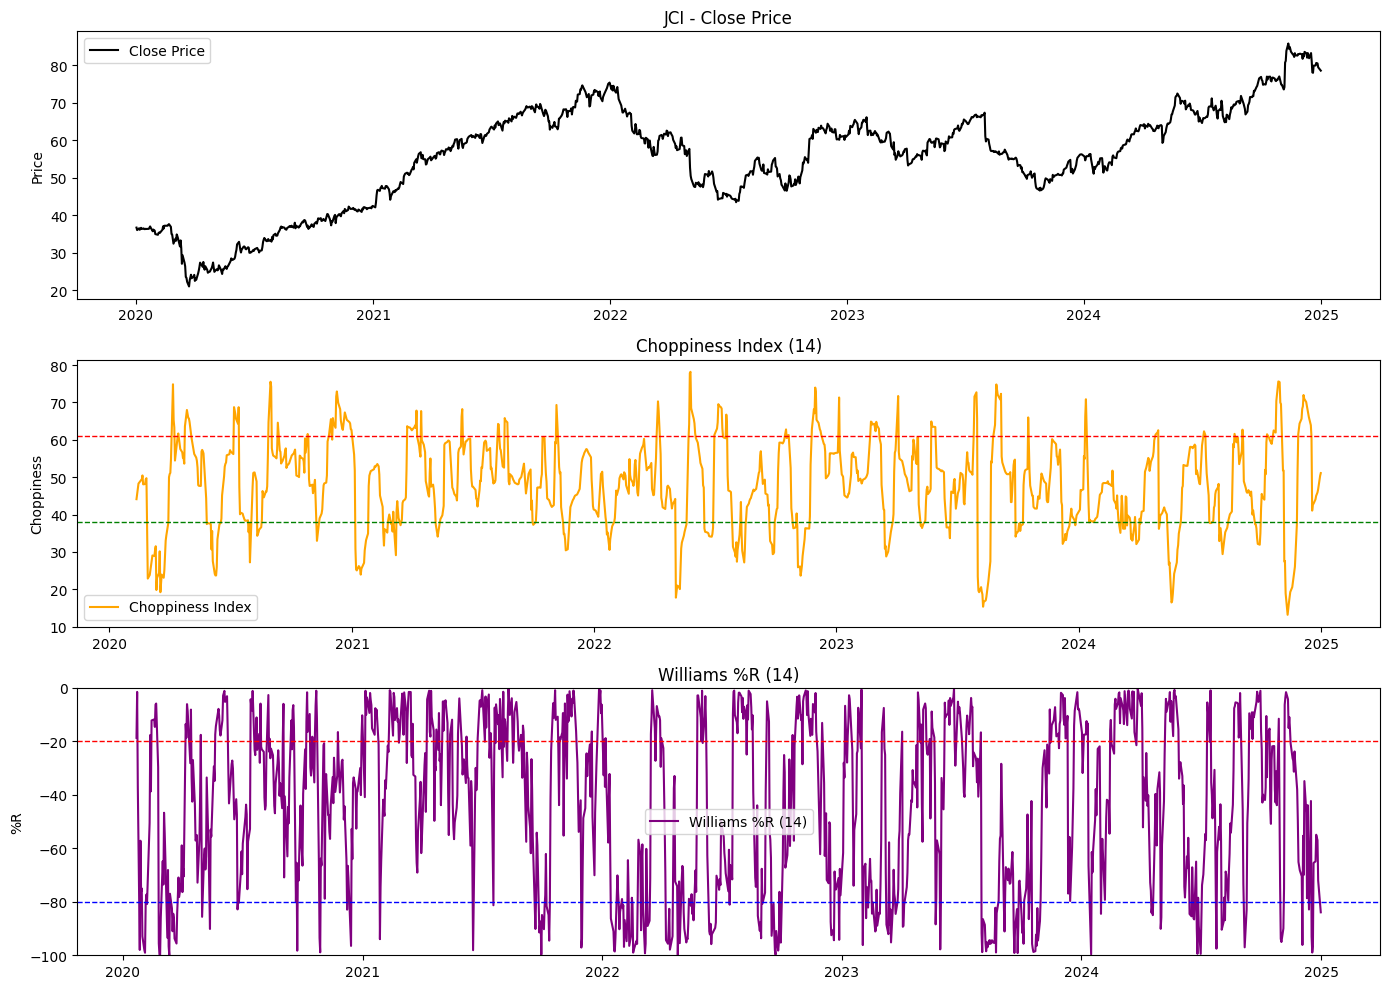

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Choppiness Index
def calculate_choppiness_index(high, low, close, period=14):
    tr = pd.Series(index=close.index, dtype='float64')
    tr[1:] = np.maximum.reduce([
        high[1:] - low[1:],
        np.abs(high[1:] - close.shift(1)[1:]),
        np.abs(low[1:] - close.shift(1)[1:])
    ])
    atr = tr.rolling(window=period).mean()
    high_max = high.rolling(window=period).max()
    low_min = low.rolling(window=period).min()
    ci = 100 * np.log10(atr.rolling(window=period).sum() / (high_max - low_min)) / np.log10(period)
    return ci

# Williams %R
def calculate_williams_r(high, low, close, period=14):
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    williams_r = -100 * (highest_high - close) / (highest_high - lowest_low)
    return williams_r

# Define the stock symbol and time period
symbol = 'JCI'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate indicators
df['Choppiness'] = calculate_choppiness_index(df['High'], df['Low'], df['Close'], period=14)
df['Williams %R'] = calculate_williams_r(df['High'], df['Low'], df['Close'], period=14)

# Plotting
plt.figure(figsize=(14, 10))

# --- Subplot 1: Price ---
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='black')
plt.title(f'{symbol} - Close Price')
plt.ylabel('Price')
plt.legend()

# --- Subplot 2: Choppiness Index ---
plt.subplot(3, 1, 2)
plt.plot(df['Choppiness'], label='Choppiness Index', color='orange')
plt.axhline(38, color='green', linestyle='--', linewidth=1)
plt.axhline(61, color='red', linestyle='--', linewidth=1)
plt.title('Choppiness Index (14)')
plt.ylabel('Choppiness')
plt.legend()

# --- Subplot 3: Williams %R ---
plt.subplot(3, 1, 3)
plt.plot(df['Williams %R'], label='Williams %R (14)', color='purple')
plt.axhline(-80, color='blue', linestyle='--', linewidth=1)
plt.axhline(-20, color='red', linestyle='--', linewidth=1)
plt.title("Williams %R (14)")
plt.ylabel('%R')
plt.ylim(-100, 0)
plt.legend()

plt.tight_layout()
plt.show()
